In [2]:
import os
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from pyproj import CRS
import contextily as ctx

In [3]:
# set place name
place_name = " Santa Maria Maior,  Lisbon, Portugal"

graph = ox.graph_from_place(place_name, network_type = "walk")

Santa Maria Maior a neighborhood within  Baixa central place in Lisbon 

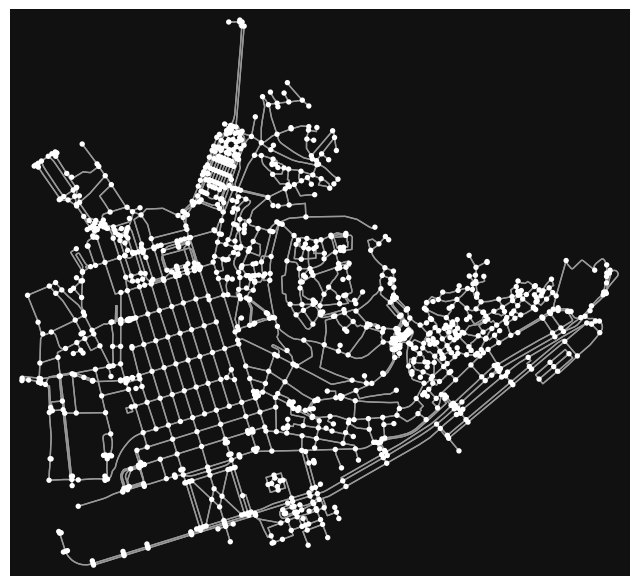

In [4]:
fig, ax = ox.plot_graph(graph)

In [5]:
# get the area of interest polygon
place_polygon = ox.geocode_to_gdf(place_name)

In [6]:
place_polygon= place_polygon.to_crs(epsg = 5018)

In [7]:
# create a buffer 
place_polygon["geometry"]=place_polygon["geometry"].buffer(300)

In [8]:
#reproject the place polygon back to WG84

place_polygon=place_polygon.to_crs(epsg = 4326)

In [9]:
#retrieve the network based on the polygon geometry

graph = ox.graph_from_polygon(place_polygon["geometry"].values[0], network_type = "walk")

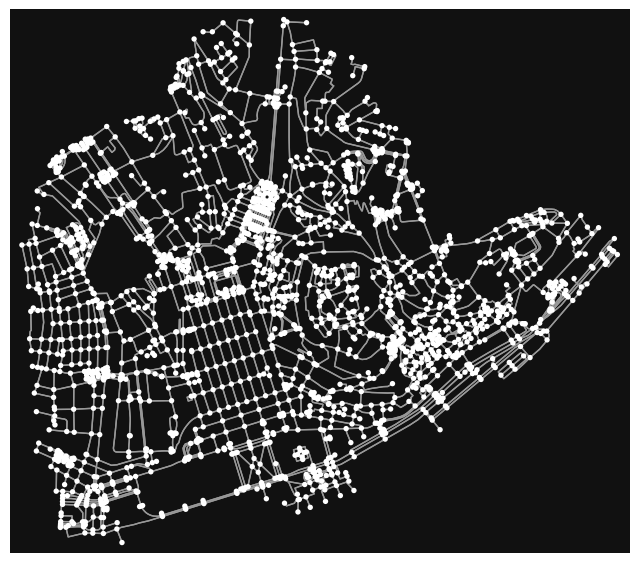

In [10]:
fig, ax=ox.plot_graph(graph)

In [11]:
# retrieve only edges from graph

edges = ox.graph_to_gdfs(graph, nodes = False, edges = True)

In [12]:
# Project the data
graph_proj = ox.project_graph(graph)

In [13]:
#get the nodes and edges
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj)

In [14]:
# check the epsg code

CRS(edges_proj.crs).to_epsg()

32629

The starting point of our journey was from Rossio just from the matro station to Terriro do Paco

In [15]:
#Analysing the network properties
#set the starting and the destination palce
#first the source place

placename = "Rossio"

In [16]:
# convert the place name to geodataframe
geocoded_place = ox.geocode_to_gdf(placename)
geocoded_place

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,"POLYGON ((-9.13899 38.71404, -9.13897 38.71397...",38.71427,38.713753,-9.137264,-9.138995,279201170,way,898569365,38.714024,-9.137941,"Rossio, Rua Dom Antão de Almada, Santa Justa, ...",railway,station,0.475945


In [17]:
# Reprojection the data
geocoded_place = geocoded_place.to_crs(edges_proj.crs)

In [18]:
# Get centroid as shapely point
origin = geocoded_place["geometry"].centroid.values[0]

In [19]:
#Set a destination place

placename = "Terreiro do Paco"
geocoded_place = ox.geocode_to_gdf(placename)

In [20]:
# reproject the destination place

geocoded_place = geocoded_place.to_crs(edges_proj.crs)

In [21]:
destination = geocoded_place["geometry"].centroid.values[0]

In [22]:
originxy=(origin.y, origin.x)
targetxy=(destination.y, destination.x)

In [23]:
# Find the node in the graph
orig_node_id =ox.nearest_nodes(graph_proj, origin.x,origin.y, return_dist= False)

In [24]:
# Find the node in the graph
target_node_id =ox.nearest_nodes(graph_proj, destination.x,destination.y, return_dist= False)

In [25]:
# retrieve the rows from the node

origin_node = nodes_proj.loc[orig_node_id]
target_node = nodes_proj.loc[target_node_id]

In [26]:
#Create a GeoDataFrame
origin_dest = gpd.GeoDataFrame([origin_node, target_node], geometry = "geometry", crs = nodes_proj.crs)

In [27]:
#calculate the shortest path
route = nx.shortest_path(graph_proj, source = orig_node_id, target = target_node_id, weight = "length")

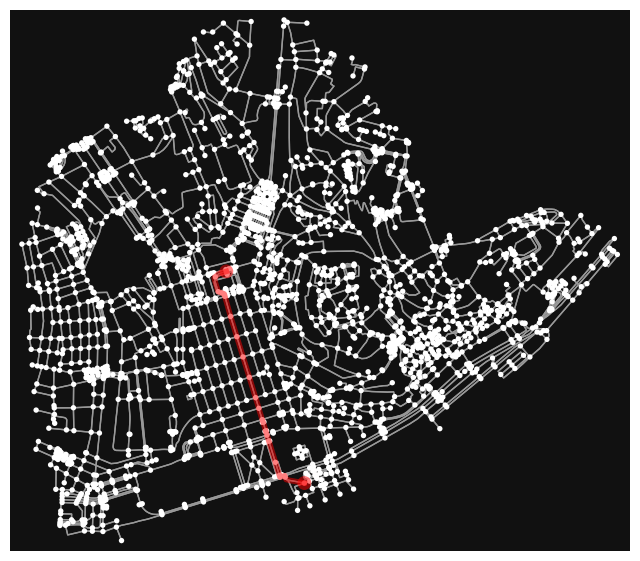

In [28]:
#plot the route
fig, ax = ox.plot_graph_route(graph_proj, route)

In [29]:
#Route String
#get the nodes along the shortest path
route_nodes = nodes_proj.loc[route]

In [30]:
from shapely.geometry import LineString, Point

In [31]:
route_line = LineString(list(route_nodes["geometry"].values))

In [32]:
#create a geometry for the route line

route_gdf = gpd.GeoDataFrame([[route_line]], geometry = "geometry", crs=edges_proj.crs, columns=["geometry"])

In [33]:
route_gdf

,geometry
0,"LINESTRING (488023.876 4285058.349, 487982.548..."


In [34]:
#calculate the route
route_gdf["length_meters"]=route_gdf.length

In [35]:
route_gdf

,geometry,length_meters
0,"LINESTRING (488023.876 4285058.349, 487982.548...",953.931752


So the shortest route from Roosio to Terreiro do Paco was 953.93m by foot

In [36]:
# retrieve the buildings from the place

tags = {"building" : True}

In [37]:
buildings = ox.geometries_from_place(place_name, tags)

In [38]:
buildings_proj = buildings.to_crs(CRS(edges_proj.crs))

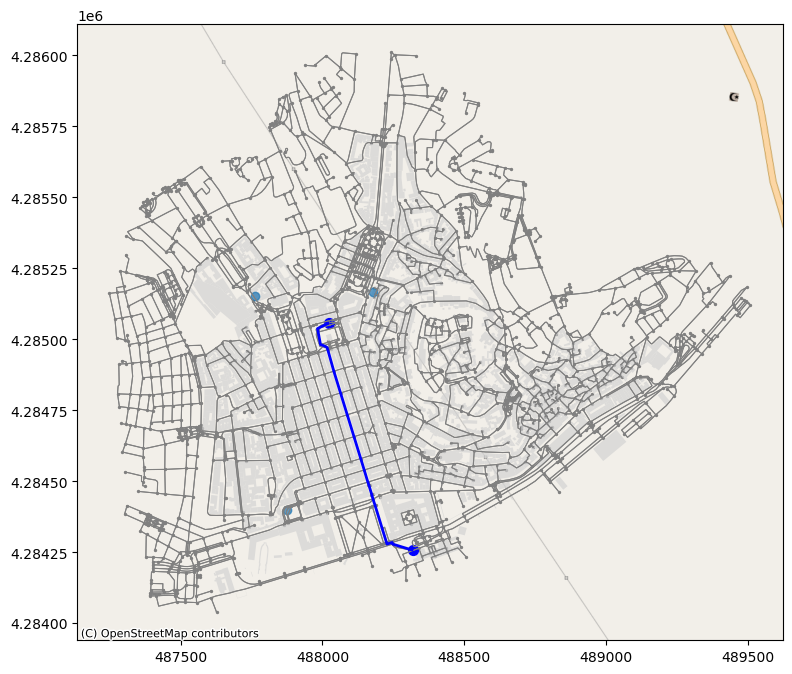

In [39]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot()
#fig, ax = plt.subplot(figsize=(10,6))

#plot the nodes and edges

edges_proj.plot(ax=ax, linewidth = 0.75, color = "gray")

nodes_proj.plot(ax=ax, markersize=2, color="gray")

#add the building
ax = buildings_proj.plot(ax=ax, facecolor = "lightgray", alpha=0.7)

#add the route

ax = route_gdf.plot(ax=ax, linewidth=2, color = "blue")

ax = origin_dest.plot(ax=ax, markersize = 50, color = "blue")

# add base#add basemap
#ctx.add_basemap(ax, source =ctx. providers.CartoDB.Positron)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

In conclusion the shortest walking distance from Roosi to Terreiro do Paco was 953.93m,
where the route pass through an interesting place where as a tourist you can experience popular resturants and shopping mall
whiles walking to the main place which is Terreiro do Paco